In [68]:
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import json
import itertools
from random import shuffle, random, randint
from sklearn.cross_validation import ShuffleSplit, train_test_split
from sklearn.cluster import MiniBatchKMeans, KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA, ProbabilisticPCA, KernelPCA, MiniBatchSparsePCA, SparsePCA
from sklearn.svm import LinearSVC, SVC, LinearSVC, SVR, NuSVR
from scipy.sparse import csr_matrix
from datetime import datetime
%matplotlib inline

In [116]:
def HaversineDistance(c1, c2): 
  lon_diff = np.abs(c1[0]-c2[0])*np.pi/360.0
  lat_diff = np.abs(c1[1]-c2[1])*np.pi/360.0
  a = np.sin(lat_diff)**2 + np.cos(c1[1]*np.pi/180.0) * np.cos(c2[1]*np.pi/180.0) * np.sin(lon_diff)**2
  d = 2*6371*np.arctan2(np.sqrt(a), np.sqrt(1-a))
  return d

def EuclidDistance(c1, c2):
    return np.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2)


def load_data(num_records_to_load=10):
    submission_df = pd.read_csv('/home/tony/ML/taxi/taxi2_time/test.csv')
    submission_df['POLYLINE'] = submission_df['POLYLINE'].apply(json.loads)
    submission_df['COORDS_LEN'] = submission_df['POLYLINE'].apply(len)
    submission_df['START'] = submission_df['POLYLINE'].apply(lambda x: x[0])

    # read train
    taxi_df = pd.read_csv('/home/tony/ML/taxi/taxi2_time/train.csv', nrows=num_records_to_load)
    taxi_df['POLYLINE'] = taxi_df['POLYLINE'].apply(json.loads)
    taxi_df['COORDS_LEN'] = taxi_df['POLYLINE'].apply(len)
    taxi_df = taxi_df[taxi_df.COORDS_LEN > 10]
    taxi_df['START'] = taxi_df['POLYLINE'].apply(lambda x: x[0])
    taxi_df['END'] = taxi_df['POLYLINE'].apply(lambda x: x[-1])
    getDateInformation(taxi_df), getDateInformation(submission_df)
    
    return taxi_df, submission_df

def getDateInformation(df):
    dates = pd.to_datetime(df['TIMESTAMP'])
    df['DATETIME'] = dates
    df['DAYOFWEEK'] = dates.apply(lambda x: x.dayofweek)
    df['HOUR'] = dates.apply(lambda x: x.hour)
    df['DAY'] = dates.apply(lambda x: x.day)
    df['IS_WEEKDAY'] = dates.apply(lambda x: 1 if x.dayofweek < 5 else 0)
    
def getPointInfos(df):
    df['START_X'] = [x[0] for x in df['START']]
    df['START_Y'] = [x[1] for x in df['START']]
    df['LAST_SEEN_X'] = [x[-1][0] for x in df['POLYLINE']]
    df['LAST_SEEN_Y'] = [x[-1][1] for x in df['POLYLINE']]
    
def getColumnsForPrediction(df):
    return df[['TRIP_ID', 'CALL_TYPE', 'TAXI_ID', 'DAYOFWEEK', 'HOUR', 'DAY', 'IS_WEEKDAY', 'START_X', 'START_Y', 'LAST_SEEN_X', 'LAST_SEEN_Y']]

def createTrainTestSplit(df, percent_test=0.1, percent_len=0.25):
    num_rows = len(df)
    num_train = num_rows - int(num_rows*percent_test)
    mask = np.random.rand(num_rows) > percent_test
    
    train_df, test_df = df[mask], df[~mask]
    train_time, test_time = 15*train_df['COORDS_LEN'].values, 15*test_df['COORDS_LEN'].values
    train_end, test_end = train_df['END'].values, test_df['END'].values

    # Save reference to complete path for analytical purposes
    test_df['POLYLINE_ACTUAL'] = test_df['POLYLINE'].values[:]
    
    #Create partial paths for the test data
    #coords = test_df['POLYLINE'].values[:]
    #partial_lengths = [round(0.5*len(coord)) for coord in coords]
    #test_df['POLYLINE'] = [coords[:n] for n in partial_lengths]
    test_df['POLYLINE'] = [coord[:int(round((0.4*np.random.rand(1)[0])*percent_len*len(coord)))] for coord in test_df['POLYLINE'].values]
    train_df['FAKE_POLYLINE'] = [coord[:int(round((0.4*np.random.rand(1)[0])*percent_len*len(coord)))] for coord in train_df['POLYLINE'].values]
    
    #Drop all data that we shouldn't have during training
    test_df = test_df.drop(['COORDS_LEN', 'END'], axis=1)
    test_df['COORDS_LEN'] = test_df['POLYLINE'].apply(len)
    
    return train_df, test_df, train_time, test_time, train_end, test_end

def travelTimeScore(pred_times, actual_times):
    score = np.sqrt(np.mean((np.log(pred_times+1)-np.log(actual_times+1))**2))
    return score

def travelEndScore(pred_ends, actual_ends):
    num_points = len(pred_ends)
    preds, actuals = pred_ends, actual_ends
    score = np.mean([HaversineDistance(preds[i], actuals[i]) for i in range(num_points)])
    return score
    
def submitTravelTime(validation_df, filename):
    validation_df[['TRIP_ID', 'TRAVEL_TIME']].to_csv(filename, index=False)
    
def submitTravelDestination(validation_df, filename):
    validation_df['LATITUDE'] = validation_df['TRAVEL_END'].apply(lambda x: x[1])
    validation_df['LONGITUDE'] = validation_df['TRAVEL_END'].apply(lambda x: x[0])
    validation_df[['TRIP_ID', 'LATITUDE', 'LONGITUDE']].to_csv(filename, index=False)
    
def randColor():
    r = lambda: randint(0,255)
    return ('#%02X%02X%02X' % (r(),r(),r()))

In [106]:
num_records, test_size = 1000, 100
taxi_df, submission_df = load_data(num_records_to_load=num_records)
train_df, test_df, train_time, test_time, train_end, test_end = createTrainTestSplit(taxi_df, test_size/float(num_records))
#print submission_df
train_df, test_df, submission_df = getNewTrainTestPoints(train_df, test_df, submission_df)
#print submission_df[['TRIP_ID', 'TAXI_ID', 'DAYOFWEEK', 'HOUR', 'DAY', 'IS_WEEKDAY', 'START_X', 'START_Y', 'LAST_SEEN_X', 'LAST_SEEN_Y']]
print train_df

      TAXI_ID  DAYOFWEEK  HOUR  DAY  IS_WEEKDAY   START_X    START_Y  \
0    20000589          3     0    1           1 -8.618643  41.141412   
2    20000320          3     0    1           1 -8.612964  41.140359   
3    20000520          3     0    1           1 -8.574678  41.151951   
4    20000337          3     0    1           1 -8.645994  41.180490   
5    20000231          3     0    1           1 -8.615502  41.140674   
6    20000456          3     0    1           1 -8.579520  41.145948   
8    20000403          3     0    1           1 -8.611794  41.140557   
9    20000320          3     0    1           1 -8.615907  41.140557   
10   20000233          3     0    1           1 -8.619894  41.148009   
11   20000520          3     0    1           1 -8.562420  41.168403   
12   20000571          3     0    1           1 -8.618868  41.155101   
13   20000233          3     0    1           1 -8.608716  41.153499   
14   20000231          3     0    1           1 -8.612208  41.14

/home/tony/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:62: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


In [117]:

def getColumnsForPrediction(df):
    return df[['TAXI_ID', 'DAYOFWEEK', 'HOUR', 'DAY', 'IS_WEEKDAY', 'START_X', 'START_Y', 'LAST_SEEN_X', 'LAST_SEEN_Y']]
    #return df[['TRIP_ID', 'CALL_TYPE', 'TAXI_ID', 'DAYOFWEEK', 'HOUR', 'DAY', 'IS_WEEKDAY', 'START_X', 'START_Y', 'LAST_SEEN_X', 'LAST_SEEN_Y']]

def getTrainPoints(df):
    df['START_X'] = [x[0] for x in df['START']]
    df['START_Y'] = [x[1] for x in df['START']]
    df['LAST_SEEN_X'] = [x[-1][0] for x in df['FAKE_POLYLINE']]
    df['LAST_SEEN_Y'] = [x[-1][1] for x in df['FAKE_POLYLINE']]
                       
def getTestPoints(df):
    df['START_X'] = [x[0] for x in df['START']]
    df['START_Y'] = [x[1] for x in df['START']]
    df['LAST_SEEN_X'] = [x[-1][0] for x in df['POLYLINE']]
    df['LAST_SEEN_Y'] = [x[-1][1] for x in df['POLYLINE']]

def getSubmissionPoints(df):
    df['START_X'] = [x[0] for x in df['START']]
    df['START_Y'] = [x[1] for x in df['START']]
    df['LAST_SEEN_X'] = [x[-1][0] for x in df['POLYLINE']]
    df['LAST_SEEN_Y'] = [x[-1][1] for x in df['POLYLINE']]

def getNewTrainTestPoints(train_df, test_df, submission_df):
    getTrainPoints(train_df)
    getTestPoints(test_df)
    getSubmissionPoints(submission_df)
    return getColumnsForPrediction(train_df), getColumnsForPrediction(test_df), getColumnsForPrediction(submission_df)


def train_it(num_records, test_size):
    taxi_df, submission_df = load_data(num_records_to_load=num_records)
    train_df, test_df, train_time, test_time, train_end, test_end = createTrainTestSplit(taxi_df, test_size/float(num_records), 0.25)

    trip_ids = submission_df['TRIP_ID']
    train_df, test_df, submission_df = getNewTrainTestPoints(train_df, test_df, submission_df)

    clf0, clf1 = RandomForestRegressor(), RandomForestRegressor()
    clf0.fit(train_df.values, [x[0] for x in train_end])
    clf1.fit(train_df.values, [x[1] for x in train_end])

    y_pred = [[x[0],x[1]] for x in zip(clf0.predict(test_df.values), clf1.predict(test_df.values))]
    score = travelEndScore(y_pred, test_end)
    print "score:", score, "num records:", num_records

    y_sub = [[x[0],x[1]] for x in zip(clf0.predict(submission_df.values), clf1.predict(submission_df.values))]
    print "saving to file"
    submission_df['TRIP_ID'] = trip_ids
    submission_df['TRAVEL_END'] = y_sub
    submitTravelDestination(submission_df, "sub_END_datetime_start_last__%d_score%d" % (num_records, score*100))
    
test_size = 1000
for num_records in [5000, 10000, 25000, 50000, 100000, 400000, 1000000, 1700000]:
    train_it(num_records, test_size)
    

/home/tony/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:62: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


IndexError: list index out of range

getting clusters


/home/tony/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:45: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


generating policies
num_records: 10000 num_centers: 25 final score: 3.33715340526
creating submisison paths
saving to file
getting clusters
generating policies
num_records: 10000 num_centers: 50 final score: 3.63441339929
creating submisison paths
saving to file
getting clusters
generating policies
num_records: 10000 num_centers: 100 final score: 3.33437754745
creating submisison paths
saving to file
getting clusters
generating policies
num_records: 10000 num_centers: 200 final score: 3.36678726144
creating submisison paths
saving to file
getting clusters
generating policies
num_records: 10000 num_centers: 300 final score: 3.65934968747
creating submisison paths
saving to file
getting clusters
generating policies
num_records: 10000 num_centers: 400 final score: 3.23095043066
creating submisison paths
saving to file
getting clusters
generating policies
num_records: 10000 num_centers: 500 final score: 3.34766007681
creating submisison paths
saving to file


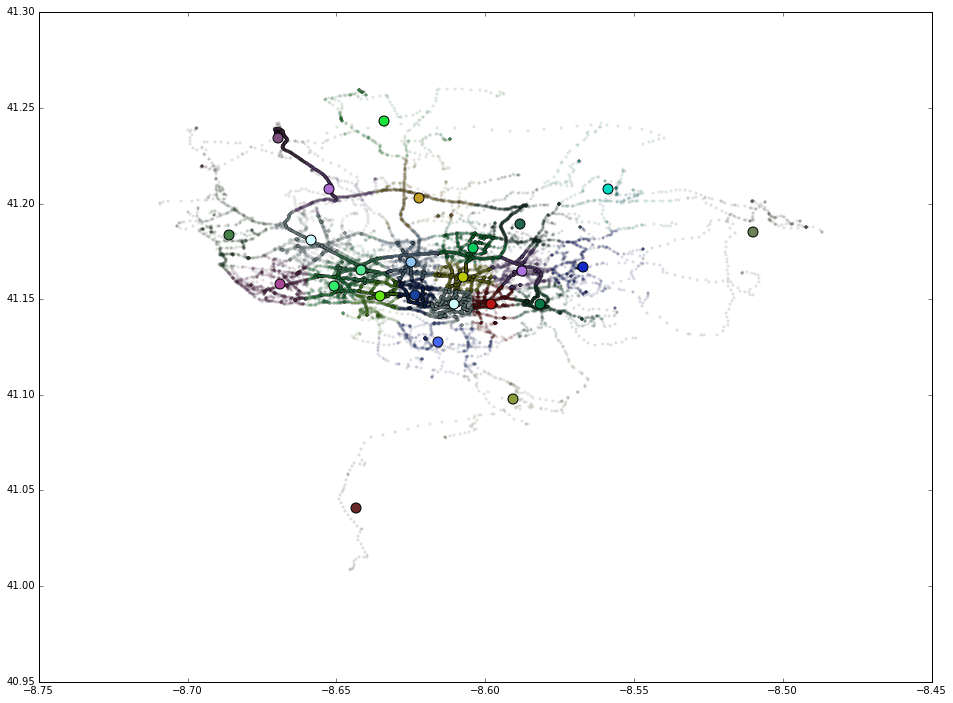

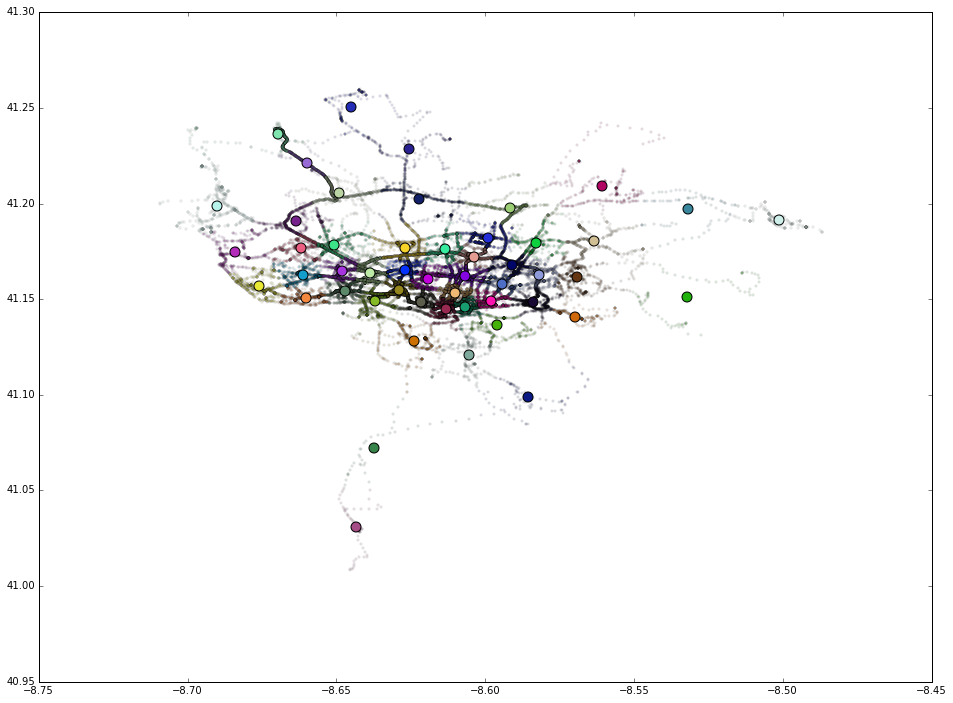

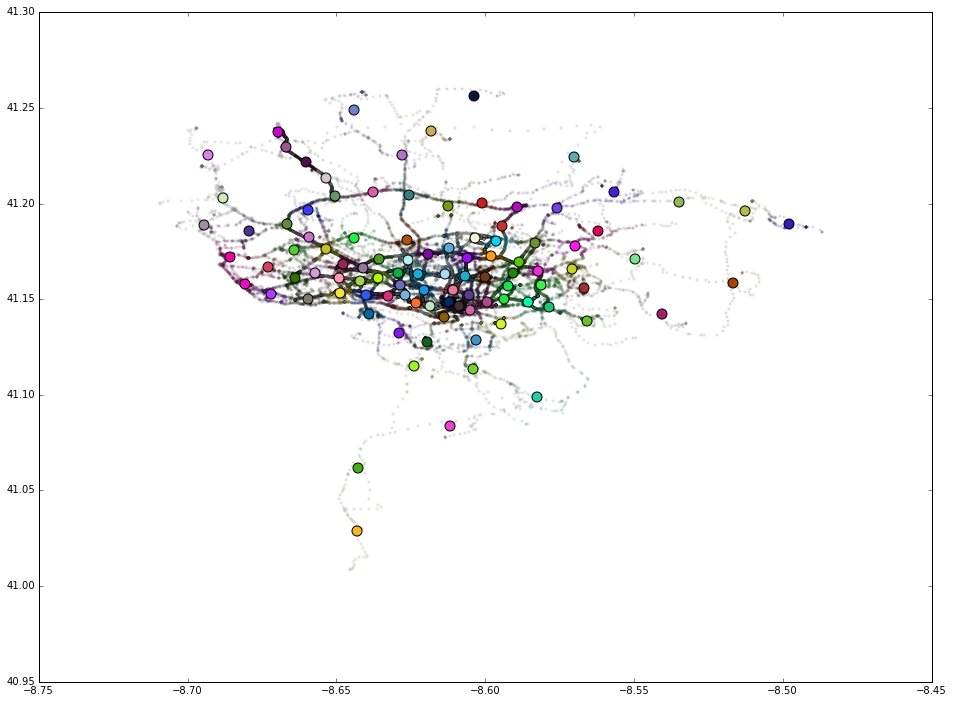

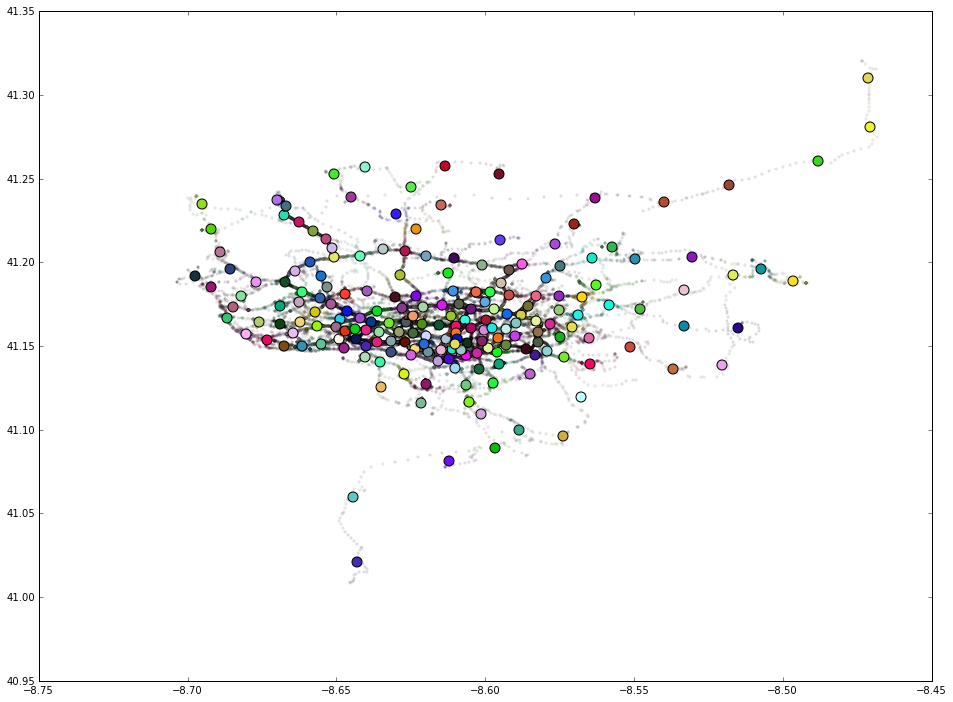

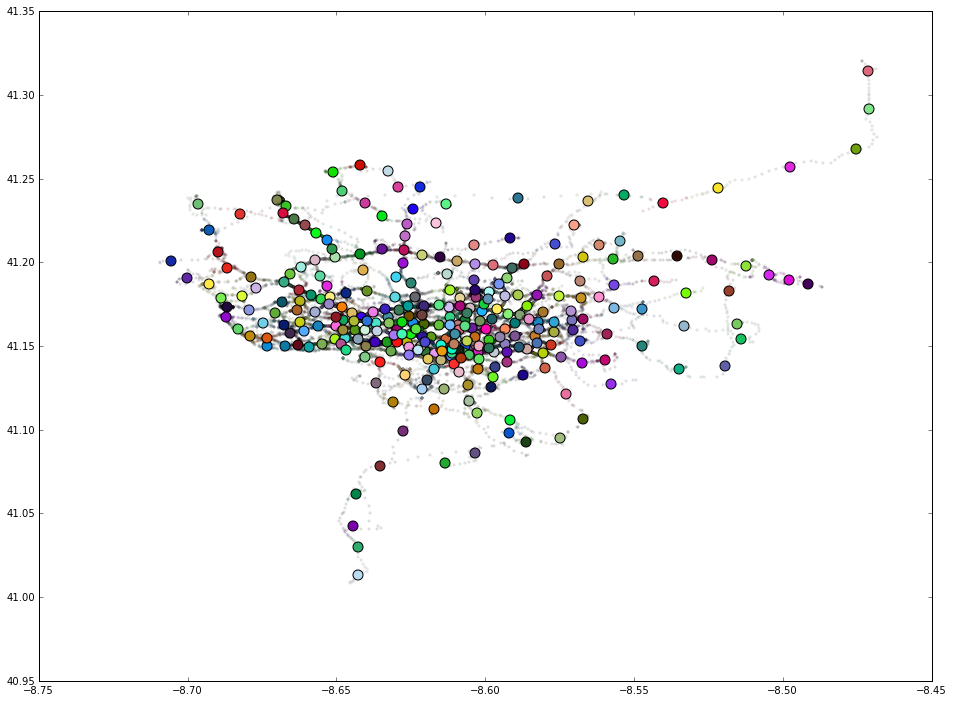

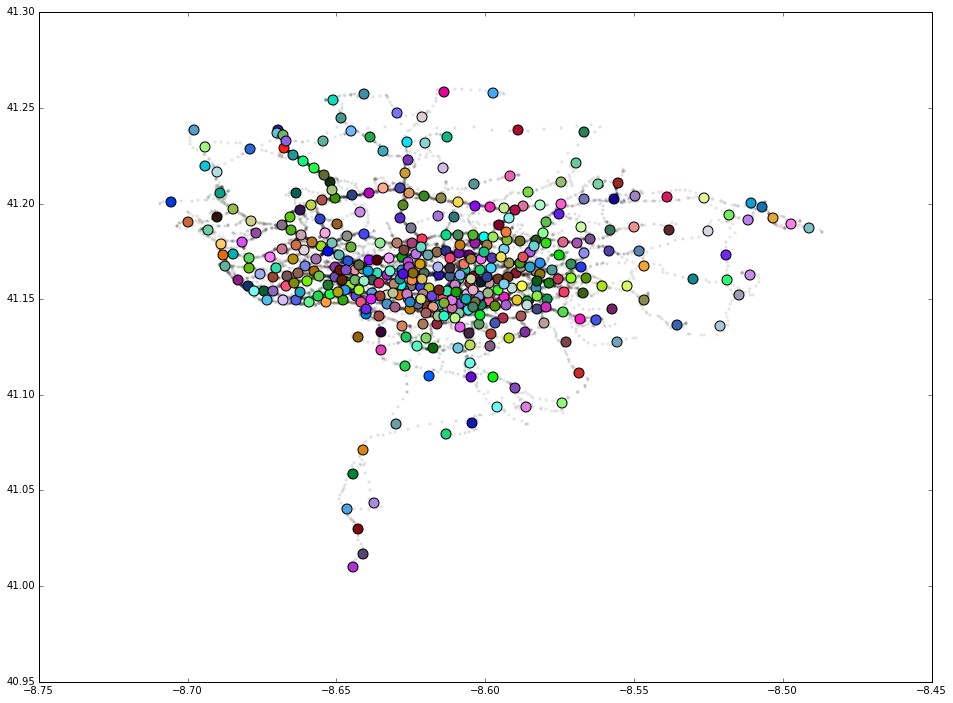

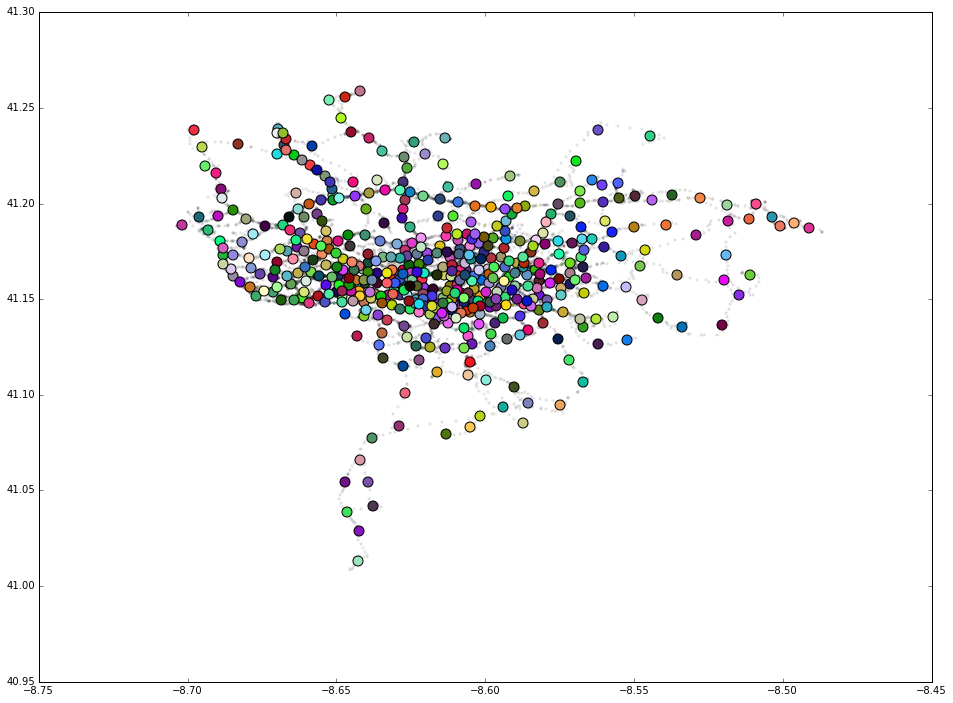

In [9]:
def path_to_policy(seq):
    return [k for k, g in itertools.groupby(seq)]

def clusterData(train_paths, num_clusters = 100, plot_it=True):
    all_coords = np.array([c for path in train_paths for c in path])
    kmeans = KMeans(n_clusters=num_clusters, n_jobs=6)
    kmeans.fit(all_coords)
    cluster_centers = kmeans.cluster_centers_
    train_grid = [path_to_policy([np.argmin(ln) for ln in kmeans.transform(path)]) for path in train_paths]


    if plot_it:
        plt.figure(figsize=(16, 12))
        all_coords_grid_weights = kmeans.transform(all_coords)
        cluster_indexes = np.array([np.argmin(x) for x in all_coords_grid_weights])
        cluster_centers = kmeans.cluster_centers_
        for k in range(num_clusters):
            color=randColor()
            plt.scatter(all_coords[:,0][cluster_indexes == k], all_coords[:,1][cluster_indexes == k], s=5, c=color, alpha=0.1)
            plt.scatter(cluster_centers[k][0], cluster_centers[k][1], s=100, c=color)

    return kmeans, train_grid, num_clusters, cluster_centers

def getGridPaths(kmeans, paths):
    return [path_to_policy([np.argmin(ln) for ln in kmeans.transform(path)]) for path in paths]

def getGridMatrix(grid_paths, k):
    return np.array([[1 if n in grid_path else 0 for n in range(k)] for grid_path in grid_paths])

def clusterIndexesToPoints(grid_y, cluster_centers):
    return [cluster_centers[k] for k in grid_y]

def getTrainTestDistMatrix(train_policies, test_policies):
    return [[jaccardSim(train_p, test_p) for train_p in train_policies] for test_p in test_policies]

def weightedMeanTravelEnd_3_Points(train_policies, test_policies, train_ends, num_trips=100):
    pred_ends = [[0,0] for x in range(len(test_policies))]
    for idx, test_policy in enumerate(test_policies):
        dists = np.array([jaccardSim(train_p, test_policy) for train_p in train_policies])
        smallest_dist_indexes = np.argpartition(dists, num_trips)[0:num_trips]
        w = np.maximum(dists[smallest_dist_indexes], 0.01)
        path_ends = train_ends[smallest_dist_indexes]
        xs, ys = [x[0] for x in path_ends], [x[1] for x in path_ends]
        pred_ends[idx] = [np.average(xs, weights=1/w**2), np.average(ys, weights=1/w**2)]
     
    return pred_ends

def do_predict(num_records, num_centers, test_size):
    taxi_df, submission_df = load_data(num_records_to_load=num_records)
    train_df, test_df, train_time, test_time, train_end, test_end = createTrainTestSplit(taxi_df, test_size/float(num_records))

    print "getting clusters"
    kmeans, zz_train_grid_paths, k, cluster_centers = clusterData(train_df['POLYLINE'].values[:len(test_df['POLYLINE'].values)], num_centers, True)
    print "generating policies"
    train_policies = getGridPaths(kmeans, train_df['POLYLINE'].values)
    test_policies = getGridPaths(kmeans, test_df['POLYLINE'].values)
    test_actual_policies = getGridPaths(kmeans, test_df['POLYLINE_ACTUAL'])

    train_ys = np.array([[x[0], x[1]] for x in train_df['END'].values])
    test_ys = np.array([[x[-1][0], x[-1][1]] for x in test_df['POLYLINE_ACTUAL']])
    
    train_policy_matrix = getGridMatrix(train_policies, k)
    test_policy_matrix = getGridMatrix(test_policies, k)
    
    y_pred = weightedMeanTravelEnd_3_Points(train_policies, test_policies, train_df['END'].values)
    

    score = travelEndScore(y_pred, test_end)
    print "num_records:", num_records, "num_centers:", num_centers, "final score:", score

    #creating submission
    print "creating submisison paths"
    submission_policies = getGridPaths(kmeans, submission_df['POLYLINE'])
    submission_policy_matrix = getGridMatrix(submission_policies, k)
    
    y_sub = weightedMeanTravelEnd_3_Points(train_policies, submission_policies, train_df['END'].values)

    print "saving to file"
    submission_df['TRAVEL_END'] = y_sub
    submitTravelDestination(submission_df, "sub_END_kmeans_regression_cntr%d_pts%d_%d.csv" % (num_records, num_centers, score*100))
    

test_size = 1000

for num_records in [10000]:
    for num_centers in [25, 50, 100, 200, 300, 400, 500]:
        do_predict(num_records, num_centers, test_size)
